In [1]:
from src.data import DataLoaders
from src import utils
import pathlib
import pandas as pd
from src.models.ModelClasses import FireRiskModels, SmokeAlarmModels
from matplotlib import pyplot as plt
from pathlib import Path
from datetime import date
import numpy as np
import geopandas as geo
import folium

In [2]:
ACS =  DataLoaders.ACSData(2016,'block_group')

In [3]:
NFIRS = DataLoaders.NFIRSData('block_group',ACS.tot_pop)
NFIRS_Sev = DataLoaders.NFIRSData('block_group',ACS.tot_pop,sev=True)

/home/kelsonss/anaconda3/envs/rcp2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
ACS_cols_to_use =[ 'did_not_work_past_12_mo',
               'house_pct_live_alone',
               'pct_alt_heat',
               'house_yr_pct_before_1960',
               'inc_pct_poverty',
               'race_pct_black_or_amind']

In [11]:
FSM =  FireRiskModels('severity')
FPM =  FireRiskModels('propensity')

In [12]:
FPM.train(NFIRS,ACS,ACS_cols_to_use)

/home/kelsonss/Documents/GitHub/rcp2/src/models/ModelClasses.py:171: RuntimeWarning: All-NaN axis encountered
  mx = np.nanmax(X, axis =1)
/home/kelsonss/anaconda3/envs/rcp2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/kelsonss/Documents/GitHub/rcp2/src/models/ModelClasses.py:218: RuntimeWarning: All-NaN axis encountered
  mx = np.nanmax(X, axis =1)


213144
202783
Predicting 2017:
Feature ranking:
1. Max (0.385028)
2. Median (0.154249)
3. pct_alt_heat (0.088281)
4. house_pct_live_alone (0.079518)
5. race_pct_black_or_amind (0.075907)
6. house_yr_pct_before_1960 (0.073211)
7. inc_pct_poverty (0.072736)
8. did_not_work_past_12_mo (0.071069)


In [13]:
FSM.train(NFIRS_Sev,ACS,ACS_cols_to_use)

213144
202783
Predicting 2017:
Feature ranking:
1. Median (0.313726)
2. Max (0.212111)
3. did_not_work_past_12_mo (0.082153)
4. race_pct_black_or_amind (0.080522)
5. pct_alt_heat (0.079632)
6. house_yr_pct_before_1960 (0.078414)
7. inc_pct_poverty (0.077514)
8. house_pct_live_alone (0.075928)


In [14]:
ARC =  DataLoaders.ARCPData()

In [15]:
ARC.data

,geoid,census_block_group_y,census_block_group_x,city,state,zip,county,in_home_visit_date,smoke_alarms_installed__9_volt_10_year_dhh_,10_year_and_9_volt_alarms_installed,...,batteries_replaced,fire_escape_plans_made,fire_safety_checklists_completed,additional_hazard_education_conducted,additional_hazard_type,people_served,youth_served,seniors_served,veterans_military_members_and_military_family_members_served,individuals_with_disabilities_access_or_functional_needs_served
12,010010205002,32.470418,-86.424166,PRATTVILLE,AL,36066,Autauga,9/9/2016,1,1,...,0,1,1,0,None,2,0,0,0,0
18,010010208012,32.455173,-86.534591,PRATTVILLE,AL,36067,Autauga,9/30/2019,2,2,...,0,1,1,1,Tornadoes,5,0,0,1,0
23,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,5/4/2019,3,2,...,0,1,1,1,Other,1,0,0,0,0
24,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,9/27/2019,1,1,...,0,1,1,1,Tornadoes,1,0,0,0,0
27,010010208023,32.543983,-86.492100,PRATTVILLE,AL,36067,Autauga,12/2/2017,3,3,...,0,1,1,0,None,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862041,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,2,2,...,0,1,1,1,Wildfires,1,0,0,0,0
862042,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,3,3,...,0,1,1,1,Wildfires,4,2,0,0,0
862043,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,3,3,...,0,1,1,1,Wildfires,2,0,1,0,1
862044,560459513003,43.843551,-104.260072,NEWCASTLE,WY,82701,Weston,3/4/2017,4,4,...,0,1,1,1,Wildfires,3,0,0,0,0


In [6]:
SVI =  DataLoaders.SVIData(ACS.data)
SVI.data

,inc_pct_poverty,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4
geos,,,,,
010010201001,0.191946,0.3913,0.5597,0.3735,0.0993
010010201002,0.044269,0.3913,0.5597,0.3735,0.0993
010010202001,0.382199,0.7065,0.3585,0.5821,0.7299
010010202002,0.111426,0.7065,0.3585,0.5821,0.7299
010010203001,0.042301,0.5659,0.8729,0.6429,0.3882
...,...,...,...,...,...
560459511001,0.094029,0.3925,0.6370,0.2331,0.8555
560459511002,0.062579,0.3925,0.6370,0.2331,0.8555
560459513001,0.261512,0.5093,0.6043,0.2862,0.6949


In [7]:
Smoke = SmokeAlarmModels()

-----Training_Performance------
107.53481706264168
Test RMSE: 10.369899568589933
Test MAE: 7.761386748275695


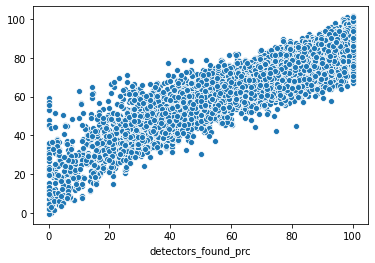

-----Test Performance ----- 
Test RMSE: 13.506176687758392
Test MAE: 10.119023991156848


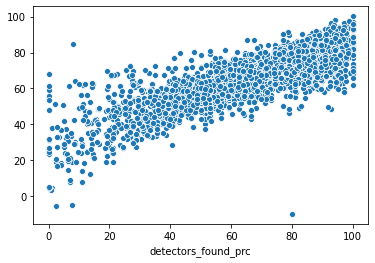

Test Correlation: (0.8207036211893618, 0.0)
Test R-squared: 0.6408872569892782

 Feature ranking:
1. RPL_THEME1 (0.282415)
2. RPL_THEME3 (0.183722)
3. RPL_THEME2 (0.173015)
4. RPL_THEME4 (0.172161)
5. Population Density (per square mile), 2010 (0.141543)
6. inc_pct_poverty (0.047144)


In [10]:
svi_use = True
smoke_prediction = Smoke.trainModels(ARC,ACS,SVI, ACS_cols_to_use,svi_use, utils.DATA['data'])

In [42]:
out = NFIRS.fires.copy()
out.columns =  'fires_per_1K_pop_' + out.columns
cols = out.columns

In [43]:
out = ACS.data.merge(out, how = 'left', left_index = True, right_index = True)
out = out[cols]

In [44]:
# Smoke Alarm model munging 


# add number of surveys recorded at the block level
num_surveys_block = Smoke.models['Block_Group']['num_surveys'].copy()
num_surveys_block.index = num_surveys_block.index.str[2:]


out['recorded_home_visits'] = num_surveys_block


# add the statistical model outputs 
Smoke_predicts = Smoke.models['MultiLevel'][
    [ 'detectors_working_prc','detectors_working_CI','geography']].copy()
Smoke_predicts.index = Smoke_predicts.index.str[2:]
out = out.merge(Smoke_predicts,how = 'left', left_index = True, right_index = True)

## add DL model to outputs
DL = pd.DataFrame(smoke_prediction['Population Density (per square mile), 2010'])
DL['detectors_predicted'] = smoke_prediction['Predictions'].copy()

out = out.merge(DL,how = 'left', left_index = True, right_index = True)

In [45]:
# add final invidual predictors 

out['smoke_detector_risk_score'] =  1 - out['detectors_predicted'] / 100
out['SVI_Theme_1'] = SVI.data['RPL_THEME1'].replace(-999.0, np.NaN)

out['fire_propensity_risk_score'] = FPM.test_prediction_probs[:,1]
out['fire_severity_risk_score'] = FSM.test_prediction_probs[:,1]



In [46]:
# create and add final predictor 

out['CombinedRiskScore'] =  out.loc[:,['smoke_detector_risk_score',
                                       'SVI_Theme_1',
                                       'fire_propensity_risk_score',
                                       'fire_severity_risk_score'] ].mean(axis = 1,
                                                                          skipna = False )

In [47]:
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,detectors_working_prc,detectors_working_CI,geography,"Population Density (per square mile), 2010",detectors_predicted,smoke_detector_risk_score,SVI_Theme_1,fire_propensity_risk_score,fire_severity_risk_score,CombinedRiskScore
GEOID,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0.0,31.38,1.089020,state,504.8,72.615242,0.273848,0.3913,0.377452,0.493698,0.384074
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0.0,31.38,1.089020,state,504.8,72.375069,0.276249,0.3913,0.033421,0.175941,0.219228
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0.0,31.38,1.089020,state,1682.5,71.071663,0.289283,0.7065,0.259547,0.917446,0.543194
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0.0,31.38,1.089020,state,1682.5,68.724457,0.312755,0.7065,0.146521,0.194808,0.340146
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0.0,31.38,1.089020,state,1633.1,58.170200,0.418298,0.5659,0.005159,0.003696,0.248263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0.0,38.90,3.199404,state,1.4,61.382938,0.386171,0.3925,0.347886,0.751559,0.469529
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0.0,38.90,3.199404,state,1.4,61.382938,0.386171,0.3925,0.407637,0.494877,0.420296
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3.0,38.90,3.199404,state,91.0,74.466530,0.255335,0.5093,0.081812,0.514243,0.340173


In [48]:
out['CombinedRiskScore'].describe()

count    213070.000000
mean          0.357558
std           0.184034
min           0.001809
25%           0.216091
50%           0.333777
75%           0.475722
max           0.964785
Name: CombinedRiskScore, dtype: float64

In [49]:
out

,fires_per_1K_pop_2009,fires_per_1K_pop_2010,fires_per_1K_pop_2011,fires_per_1K_pop_2012,fires_per_1K_pop_2013,fires_per_1K_pop_2014,fires_per_1K_pop_2015,fires_per_1K_pop_2016,fires_per_1K_pop_2017,recorded_home_visits,detectors_working_prc,detectors_working_CI,geography,"Population Density (per square mile), 2010",detectors_predicted,smoke_detector_risk_score,SVI_Theme_1,fire_propensity_risk_score,fire_severity_risk_score,CombinedRiskScore
GEOID,,,,,,,,,,,,,,,,,,,,
010010201001,1.342282,2.684564,NaN,NaN,NaN,NaN,NaN,1.342282,1.342282,0.0,31.38,1.089020,state,504.8,72.615242,0.273848,0.3913,0.377452,0.493698,0.384074
010010201002,1.581028,0.790514,NaN,1.581028,0.790514,NaN,1.581028,0.790514,NaN,0.0,31.38,1.089020,state,504.8,72.375069,0.276249,0.3913,0.033421,0.175941,0.219228
010010202001,1.047120,NaN,3.141361,NaN,1.047120,1.047120,1.047120,1.047120,NaN,0.0,31.38,1.089020,state,1682.5,71.071663,0.289283,0.7065,0.259547,0.917446,0.543194
010010202002,2.832861,2.832861,2.832861,0.944287,0.944287,NaN,0.944287,NaN,3.777148,0.0,31.38,1.089020,state,1682.5,68.724457,0.312755,0.7065,0.146521,0.194808,0.340146
010010203001,0.846024,1.269036,0.846024,0.423012,1.269036,0.423012,0.423012,0.846024,NaN,0.0,31.38,1.089020,state,1633.1,58.170200,0.418298,0.5659,0.005159,0.003696,0.248263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372684,NaN,0.0,38.90,3.199404,state,1.4,61.382938,0.386171,0.3925,0.347886,0.751559,0.469529
560459511002,0.632111,NaN,NaN,NaN,NaN,NaN,0.632111,NaN,NaN,0.0,38.90,3.199404,state,1.4,61.382938,0.386171,0.3925,0.407637,0.494877,0.420296
560459513001,0.868810,NaN,0.868810,NaN,0.868810,0.868810,NaN,NaN,1.737619,3.0,38.90,3.199404,state,91.0,74.466530,0.255335,0.5093,0.081812,0.514243,0.340173


In [50]:
out_name = f"CombinedModels-{date.today()}.csv"
out.index = '#_' + out.index
out.to_csv(utils.DATA['model-outputs'] / out_name)

In [51]:
# alternate risk score ideas 

#out['CombinedRiskScore'] = (out[["fire_severity_risk_score", "fire_propensity_risk_score"]].max(axis=1) + out['smoke_detector_risk_score'])*100